In [1]:
"""

Face Recognition with OpenCV and LBPHFaceRecognizer
This Jupyter Notebook demonstrates a simple face recognition system using OpenCV's LBPHFaceRecognizer.
The code loads training images, detects faces, trains a recognizer, and then predicts the person in a test image. 
The goal is to walk through each step and display intermediate results.

"""

"\n\nFace Recognition with OpenCV and LBPHFaceRecognizer\nThis Jupyter Notebook demonstrates a simple face recognition system using OpenCV's LBPHFaceRecognizer.\nThe code loads training images, detects faces, trains a recognizer, and then predicts the person in a test image. \nThe goal is to walk through each step and display intermediate results.\n\n"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [3]:
def load_image(img_path):
    try:
        pil_img = Image.open(str(img_path)).convert('RGB')
        img = np.array(pil_img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img
    except Exception as e:
        print(f"Error loading image: {img_path}\n{e}")
        return None


In [4]:
def detect_and_extract_face(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    faces = face_classifier.detectMultiScale(
        gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
    )
    if len(faces) == 0:
        return None
    # Assuming one face per image
    (x, y, w, h) = faces[0]
    face_img = gray_image[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (200, 200))
    # Apply histogram equalization
    face_img = cv2.equalizeHist(face_img)
    return face_img


In [5]:
def load_faces_from_folder(folder_path):
    image_files = list(folder_path.glob('*.jpg')) + list(folder_path.glob('*.png'))
    faces = []
    labels = []
    image_names = []
    label_map = {}
    current_label = 0
    for img_file in image_files:
        img = load_image(img_file)
        if img is not None:
            face = detect_and_extract_face(img)
            if face is not None:
                faces.append(face)
                # Use the person's name as the label (assuming file name is person's name)
                label_name = img_file.stem  # Get the file name without extension
                if label_name not in label_map:
                    label_map[label_name] = current_label
                    current_label += 1
                labels.append(label_map[label_name])
                image_names.append(img_file.name)
                # Save extracted face for inspection
                face_save_path = img_file.parent / f"extracted_{img_file.name}"
                cv2.imwrite(str(face_save_path), face)
            else:
                print(f"No face detected in image: {img_file.name}")
        else:
            print(f"Failed to load image: {img_file.name}")
    return faces, labels, image_names, label_map


In [6]:
# Paths to the directories
test_img_path = Path(r'C:\Users\luish\OneDrive\Área de Trabalho\FIAP\FIAP Projetos Ano 2\FASE 06\PBI\RECONHECIMENTO FACIAL\IMG_TESTE')
training_img_path = Path(r'C:\Users\luish\OneDrive\Área de Trabalho\FIAP\FIAP Projetos Ano 2\FASE 06\PBI\RECONHECIMENTO FACIAL\IMG_TESTE - TREINO')

In [7]:
# Load and process the training images
training_faces, training_labels, training_image_names, label_map = load_faces_from_folder(training_img_path)
if not training_faces:
    print("No faces detected in the training images.")
    exit()


In [8]:
# Convert faces and labels to correct types
training_faces = [np.array(face, dtype=np.uint8) for face in training_faces]
training_labels = np.array(training_labels, dtype=np.int32)


In [9]:
# Print labels and corresponding image names
print("\nTraining Labels and Image Names:")
for label, img_name in zip(training_labels, training_image_names):
    person_name = [name for name, lbl in label_map.items() if lbl == label][0]
    print(f"Label: {label}, Person: {person_name}, Image: {img_name}")



Training Labels and Image Names:
Label: 0, Person: Angelina Jolie, Image: Angelina Jolie.jpg
Label: 1, Person: Brad Pitt, Image: Brad Pitt.jpg
Label: 2, Person: Luis Santos, Image: Luis Santos.jpg
Label: 3, Person: Paul Walker, Image: Paul Walker.jpg
Label: 4, Person: Terry Crews, Image: Terry Crews.jpg


In [10]:
# Train the recognizer with the training faces
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(training_faces, training_labels)


In [11]:
# Load and process the test image
test_faces, _, test_image_names, _ = load_faces_from_folder(test_img_path)
if not test_faces:
    print("No faces detected in the test image(s).")
    exit()
test_face = test_faces[0]
test_image_name = test_image_names[0]


In [12]:
# Predict the label of the test face
label_predicted, confidence = recognizer.predict(test_face)

# Map the predicted label back to the person's name
label_name_map = {v: k for k, v in label_map.items()}
matched_person_name = label_name_map.get(label_predicted, "Unknown")
matched_image_name = training_image_names[training_labels.tolist().index(label_predicted)]

print(f"\nThe test image '{test_image_name}' matches with the training image '{matched_image_name}'.")
print(f"Matched Person: {matched_person_name}")
print(f"Confidence: {confidence}")



The test image 'Terry Crews 02.jpg' matches with the training image 'Terry Crews.jpg'.
Matched Person: Terry Crews
Confidence: 63.64896232174704


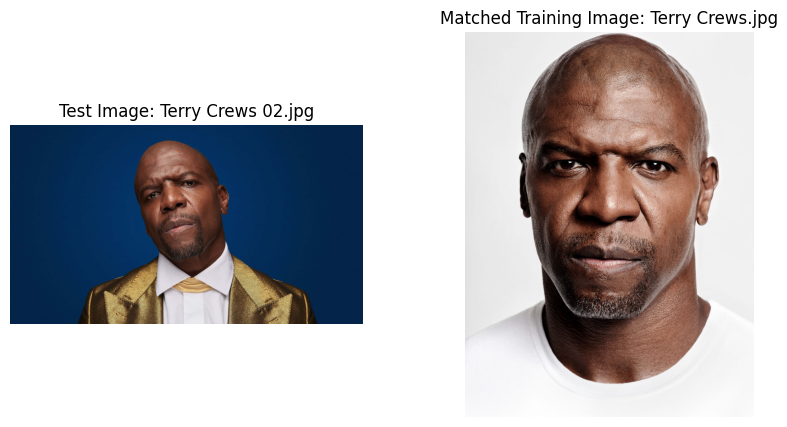

In [13]:
def display_images(test_img_name, matched_img_name):
    test_img = load_image(test_img_path / test_img_name)
    matched_img = load_image(training_img_path / matched_img_name)

    # Convert images to RGB for displaying with matplotlib
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img_rgb)
    plt.title(f"Test Image: {test_img_name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(matched_img_rgb)
    plt.title(f"Matched Training Image: {matched_image_name}")
    plt.axis('off')

    plt.show()

# Display the images
display_images(test_image_name, matched_image_name)
